# CAO POINTS ANALYSIS
### AUTHOR: ANTE DUJIC
<hr style="border:2px solid black"> </hr>

## INTRODUCTION
<hr style="border:2px solid gray"> </hr>

This notebook gives an overview of how to load CAO points information from the CAO website into a pandas data frame and the comparison of CAO points in 2019, 2020, and 2021. It is shown below how to collect the data, clean the data and finally analyse the data.

[<center><img src="http://www.cao.ie/images/cao.png" width="100"/></center> ](http://www.cao.ie/index.php)

***
### CONTENTS

- [WHAT IS CAO?](#CAO)
- [LEVEL 8 - ROUND 1 and ROUND 2](#R1R2)
- [LEVEL 8 - EOS and MID](#MIDEOS)
- [CONCATENATING THE DATA](#CONCATENATE)
- [DATA ANALYSIS](#ANALYSIS)

## WHAT IS CAO? <a id='CAO'></a>
<hr style="border:2px solid gray"> </hr>

The purpose of the Central Applications Office (CAO) is to process centrally applications for undergraduate courses in Irish Higher Education Institutions (HEIs), and to deal with them in an efficient and fair manner. [1]

Students applying for admission to third level education courses in Ireland apply to the CAO rather than to individual educational institutions such as colleges and universities. The CAO then offers places to students who meet the minimum requirements for a course for which they have applied. If for a particular course there are more qualified applicants than available places, the CAO makes offers to those applicants with the highest score in the CAO points system. If students do not accepts offers, or later decline them because they receive an offer for another course, the CAO makes further offers until all of the places have been filled or until the offer season closes. [2]

First, I've imported all necessary libraries.

In [1]:
# HTTP request.
import requests as rq

# Regular expressions.
import re

# Dates and time.
import datetime as dt

# Data frames.
import pandas as pd

# For downloading.
import urllib.request as urlrq

# PDF.
import camelot

# To use unescape function.
import html

# Arrays.
import numpy as np

# Plotting.
import matplotlib.pyplot as plt
import seaborn as sns

<br>
Current data and time are used for the filenames that will get created to save the original data and the cleaned data. I've used the date and time for easier access and organization of the data, but also to avoid the overwriting of the data files.

In [2]:
# Current date and time.
now = dt.datetime.now()
# Format as a string.
nowstr = (now.strftime("%Y%m%d_%H%M%S"))

## LEVEL 8 - ROUND 1 and ROUND 2 <a id='R1R2'></a>
<hr style="border:2px solid gray"> </hr>

The data for Round 1 and Round 2 for the three given years (2019., 2020., 2021.) has been pulled from the CAO website. As mentioned in the README, CAO practice is to first upload the data with only Round 1 and Round 2 points and then overwrite that data with EOS and MID points sometimes after the academic year starts. To obtain the Round 1 and Round 2 data for the 2019. and 2020. I have used [The Internet Archive](https://web.archive.org/). This didn't only allow me access to the archived version of the website but also gave me the same format and the structure of the data for all the years.

### THE ORIGINAL DATA STRUCTURE
***

Original data: <br>
2019: https://web.archive.org/web/20191019135815/http://www2.cao.ie:80/points/l8.php <br>
2020: https://web.archive.org/web/20201108133105/http://www2.cao.ie/points/l8.php <br>
2021: http://www2.cao.ie/points/l8.php

The data for Round 1 and Round 2 points on the CAO website has the following structure:
- Title
- Information on how to read the data
- List of colleges
- Title
- Points
    - Course code
    - Course title
    - Round 1 points
    - Round 2 points

The data of interest is contained under the *Points* section of the website. It is explained below how the data was scrapped, cleaned and saved for the later analysis.

### SCRAPPING AND CLEANING THE DATA
***

<br>
To loop through the years and run multiple lines of code for each year in one go, I've created the dictionary below.

In [3]:
# Defining a dictionary.
years_dict = {
    "2019": [("data/cao2019_" +  nowstr), "https://web.archive.org/web/20191019135815/http://www2.cao.ie:80/points/l8.php"],
    "2020": [("data/cao2020_" +  nowstr), "https://web.archive.org/web/20201108133105/http://www2.cao.ie/points/l8.php"],
    "2021": [("data/cao2021_" +  nowstr), "http://www2.cao.ie/points/l8.php"]
}

STEPS:
<br>
1. Save the original html
<br>
This was done to ensure the original website format from which the data was scrapped is kept, in case of any future changes on the CEO website itself. The data was fetched from the given url-s and it was encoded (cp1252), due to symbols in certain course names not being supported. NOTE: Encoding on the website is wrong.
<br>
2. Read the data and filter out only the relevant data
<br>
The fetched data was ittered through and filtered out using the below regular expression. Regular expression is a sequence of characters that specifies a search pattern. Usually such patterns are used by string-searching algorithms for "find" or "find and replace" operations on strings, or for input validation. [4] The set regular expression filters out only the lines starting with the course code (e.g. AL801). Also, Symbol "&" instead "and" was used in certain 2019 and 2020 course names and it was being rendered as &amp;amp; when saving to csv. To avoid this unescape function was used. The data was also structured to fit the csv file - split and divided by commas to create 4 columns "CODE", "TITLE", "R1_POINTS", "R2_POINTS"


In [4]:
# Regular expression.
re_course = re.compile(r"([A-Z]{2}[0-9]{3})(.*)")

3. Save the cleaned data as csv files

In [5]:
# Loop through the (dict) years.
for year, content in years_dict.items():
    # Fetch the CAO points URL.
    rq.get (content[1])
    resp = rq.get (content[1])
    # The server uses the wrong encoding.
        # Change to "cp1252".
    resp.encoding = "cp1252"
    # Check if OK:
        #Response [200] means OK.
    print (year,resp)
    
    # Save the original html file.
    with open(content[0] + ".html", "w") as f:
        f.write(resp.text)
        
    # Keep track of how many courses we process.
    no_lines = 0
    # Iterating through the lines.
    resp.iter_lines()
    resps = resp.iter_lines()
    
    # Open the csv file for writing (saving)
    with open(content[0] + ".csv", "w") as f:
        # Cleaning the data.
        # Write a header row.
        f.write(','.join(["CODE", "TITLE", "R1_POINTS", "R2_POINTS"]) + "\n")
        # Loop through lines of the response.
        for line in resps:
            # Decode the line.
            dline = line.decode("cp1252")
            # Converting &amp; to &.
            dline = html.unescape(dline)
            # Match only the lines representing courses.
            if re_course.fullmatch(dline):
                # Add one to the lines counter.
                no_lines = no_lines + 1
                # The course code.
                course_code = dline[:5]
                # The course title.
                course_title = dline[7:57]
                # Round one points.
                course_points = re.split(" +", dline[60:])
                if len(course_points) != 2:
                    course_points = course_points[:2]
                # Join the fields using a comma.
                linesplit = [course_code, course_title, course_points[0], course_points[1]]
                # Rejoin the substrings with commas in between.
                f.write(",".join(linesplit) + "\n")   
    # Print the total number of processed lines.
    print("Total number of lines(courses) in CAO", year, "database is", no_lines)

2019 <Response [200]>
Total number of lines(courses) in CAO 2019 database is 930
2020 <Response [200]>
Total number of lines(courses) in CAO 2020 database is 961
2021 <Response [200]>
Total number of lines(courses) in CAO 2021 database is 949


### CLEANED DATA
***

#### 2019
***

In [6]:
# Read csv file.
df_2019 = pd.read_csv ("data/cao2019_" +  nowstr + ".csv", encoding = "cp1252")
# Name the columns.
df_2019.columns = ["CODE","TITLE", "R1_2019", "R2_2019"]
# Output random 10 rows
df_2019.sample(n = 10)

,CODE,TITLE,R1_2019,R2_2019
214,DC113,Global Business (Germany) ...,440,NaN
54,CW808,Media and Public Relations ...,262,248
300,DT358,Logistics and Supply Chain Management ...,300,NaN
111,CK108,Arts International - 4 years ...,429,NaN
576,GA580,Software and Electronic Engineering ...,301,NaN
822,MH502,Law (options) ...,410,NaN
157,CK703,Pharmacy ...,577,NaN
519,DN451,Children`s and General Nursing (Integrated) ...,488,475
181,DB504,Computing (Web and Mobile Technology) ...,265,227
487,TR091,General Nursing (Meath and St James`s) ...,402,398


#### 2020
***

In [7]:
# Read csv file.
df_2020 = pd.read_csv ("data/cao2020_" +  nowstr + ".csv", encoding = "cp1252")
# Name the columns.
df_2020.columns = ["CODE","TITLE", "R1_2020", "R2_2020"]
# Output random 10 rows.
df_2020.sample(n = 10)

,CODE,TITLE,R1_2020,R2_2020
278,DL830,Design for Stage and Screen (Character Makeup ...,#939,NaN
959,WD212,Recreation and Sport Management ...,270,NaN
553,DK843,Engineering (Common Entry) ...,340,340
296,GC305,International Hospitality Management ...,253,253
793,LM058,Financial Mathematics ...,403,NaN
826,MU002,Theology ...,440,NaN
410,TU941,Botanical Cuisine ...,249,NaN
220,DC113,Global Business (Germany) ...,462,NaN
226,DC119,Global Business (Canada) ...,564,NaN
559,DK861,Arts ...,302,302


#### 2021
***

In [8]:
# Read csv file.
df_2021 = pd.read_csv ("data/cao2021_" +  nowstr + ".csv", encoding = "cp1252")
# Name the columns.
df_2021.columns = ["CODE","TITLE", "R1_2021", "R2_2021"]
# Output random 10 rows.
df_2021.sample(n = 10)

,CODE,TITLE,R1_2021,R2_2021
420,TU974,Fine Art (portfolio) ...,#549,NaN
270,DC291,Arts (Joint Honours) - Media Studies ...,350,NaN
897,TL845,Civil Engineering ...,361,NaN
458,TR039,Computer Science Linguistics and a Language ...,443,NaN
295,GC301,Accounting and Finance ...,NaN,251
191,DB512,Business Studies ...,243,210
397,TU921,Digital Marketing Technologies ...,230,NaN
745,LC372,Music Technology and Production ...,377,NaN
313,AD103,Textile and Surface Design and Jewellery and O...,#505,NaN
421,TU975,Interior Design (portfolio) ...,#544,NaN


## 2. LEVEL 8 - EOS and MID <a id='MIDEOS'></a>
<hr style="border:2px solid gray"> </hr>

As mentioned in README, EOS and MID points data becomes available after the start of the academic year, and are only available for 2019. and 2020. in the time of making this project. However, the project could be updated in the future when the data becomes available for 2021.

### 2019 - THE PDF FILE STRUCTURE
***

Original data: <br>
2019: http://www2.cao.ie/points/lvl8_19.pdf <br>

Data containing EOS and MID points for 2019 is in pdf format.
The file has the following structure:
- Title and the Subtitles of the file
- Information on the file
- Information on how to read the data
- Points table
    - Course code
    - Institution and Course
    - EOS points
    - MID points

The data of interest is contained under the table section of the file. It is explained below how the data was scrapped, cleaned and saved for the later analysis.

### SCRAPPING AND CLEANING THE DATA
***

STEPS:
<br>
1. Save the original file <br>
Same as with the R1 and R2 points, I've saved the original file locally. The data is fetched from the given url using *requests* library.

In [9]:
# Creating a file path for the original data.
path_pdf = 'data/cao2019_em_' + nowstr + '.pdf'

In [10]:
# Fetch the CAO points URL.
resp_pdf = rq.get("http://www2.cao.ie/points/lvl8_19.pdf")
resp_pdf # <Response [200]> means OK

<Response [200]>

In [11]:
# Save the original file.
with open(path_pdf, 'wb') as f:
    f.write(resp_pdf.content)


2. Read the pdf file and filter out the table only 
<br>
The saved data is read using camelot.

In [12]:
# Read the pdf file.
tables = camelot.read_pdf(path_pdf, pages = "all", flavor = "lattice")


3. Concatenate the tables read 
<br>
Camelot reads the file and returns a table for each page. It is not possible to return one table from all the pages. Therefore, all the tables have to be concatenated.
<br>
4. Save the data as csv file 
<br>
The concatenated table is saved as csv file.

In [13]:
# Check the total number of tables read to decide the loop range.
print ("Tables:", tables.n)

Tables: 18


In [14]:
# Create empty list.
table_total = []
# Loop through all 18 tables.
for x in range (0,18):
    df = tables[x].df
    # Append all 18 tables to table_total.
    table_total.append(df)

# Concatenate all tables.  
table = pd.concat(table_total)
# Remove old column names.
table = table.iloc[1: , :]
# Name the columns.
table.columns = ["CODE","TITLE", "EOS_2019", "MID_2019"]
# Sort table by "CODE" column
    # to remove irrelevant data (college names).
table.sort_values("CODE", inplace = True)
# Remove first 35 rows (college names).
table = table.iloc[35: , :]
# Save csv file.
table.to_csv("data/cao2019_em_" +  nowstr + ".csv", index = False)

### CLEANED DATA
***

In [15]:
# Read csv file.
df_em_2019 = pd.read_csv ("data/cao2019_em_" +  nowstr + ".csv", encoding = "cp1252")
# Output random 10 rows
df_em_2019.sample(n = 10)

,CODE,TITLE,EOS_2019,MID_2019
365,DN453,Mental Health Nursing,379,403.0
904,WD117,Psychiatric Nursing,361,382.0
335,DL837,New Media Studies,290,349.0
502,GC401,Accounting and Finance (Dublin),181,309.0
704,MH207,Data Science,434,466.0
464,GA482,Quantity Surveying and Construction Economics,280,340.0
36,AL863,Graphic and Digital Design (portfolio),#703,898.0
506,GC407,"Business Studies (Marketing, Dublin)",246,330.0
633,LM020,Law and Accounting,436,476.0
416,DT398,Human Resource Management,375,388.0


In [16]:
# Confirming number of courses against the rounds table 2019.
em2019 = df_em_2019.shape[0]
print ("There are {} courses listed in this table.".format(em2019))

There are 930 courses listed in this table.


### 2020 - THE XLSX FILE STRUCTURE
***

Original data: <br>
2020: http://www2.cao.ie/points/CAOPointsCharts2020.xlsx

Data containing EOS and MID points for 2020 is in xlsx format. It contains the data for LEVEL 6, 7 and 8. The file has the following structure:
The file has the following structure:
- Title and the Subtitles of the file
- Information on the data in the file
- Information on how to read the data
- Points table


The data of interest is contained under the columns *COURSE TITLE, COURSE CODE2, EOS* and *EOS Mid-point*. It is explained below how the data was scrapped, cleaned and saved for the later analysis.

### SCRAPPING AND CLEANING THE DATA
***

STEPS:
<br>
1. Save the original file <br>
To fetch the data from the pdf file I've used the *urllib.request* library. It is fetched from the given url and saved locally.

In [17]:
# Create a file path for the original data.
path_xlsx = ("data/cao2020_em_" +  nowstr + ".xlsx")

# Copying network xlsx file.
urlrq.urlretrieve('http://www2.cao.ie/points/CAOPointsCharts2020.xlsx', path_xlsx)

('data/cao2020_em_20220102_190552.xlsx',
 <http.client.HTTPMessage at 0x24d8efe4610>)

2. Read the xlsx file and clear the data <br>
File contains irrelevant data in the first 10 rows, which I've ignored when reading the file. I've then filtered out the relevant data from the table.

In [18]:
# Download and parse the excel spreadsheet.
df2020_eos = pd.read_excel("http://www2.cao.ie/points/CAOPointsCharts2020.xlsx", skiprows = 10)

# Filter out only level 8 courses.
df2020_eos = df2020_eos.loc[df2020_eos["LEVEL"] == 8]
# Filter out only relevant columns.
df2020_eos = df2020_eos [["COURSE CODE2", "COURSE TITLE", "EOS", "EOS Mid-point"]]
# Change column names.
df2020_eos.columns = ["CODE","TITLE", "EOS_2020", "MID_2020"]


3. Save the data as csv file

In [19]:
# Save pandas data frame.
df2020_eos.to_csv("data/cao2020_em_" +  nowstr + ".csv", index = False)

### CLEANED DATA
***

In [20]:
# Read csv file.
df_em_2020 = pd.read_csv ("data/cao2020_em_" +  nowstr + ".csv")
# Output random 10 rows.
df_em_2020.sample(n = 10)

,CODE,TITLE,EOS_2020,MID_2020
401,GA683,Agricultural Engineering,309,385
882,TU805,Engineering (General Entry),402,466
727,SG449,Medical Biotechnology,341,395
205,DB504,Computing (Web and Mobile Technology),281,281
383,GA187,Rural Enterprise and Agri-Business,281,352
532,LC263,Clinical Technology,294,359
746,TL880,Early Childhood Care and Education,307,349
643,MH207,Data Science,445,520
265,DC204,Athletic Therapy and Training,519,533
112,CK740,Midwifery,473,507


In [21]:
# Confirming number of courses against the rounds table 2020.
em2020 = df_em_2020.shape[0]
print ("There are {} courses listed in this table.".format(em2020))

There are 1027 courses listed in this table.


## CONCATENATING THE DATA <a id='CONCATENATE'></a>
<hr style="border:2px solid gray"> </hr>

After cleaning and saving all the data, I've merged them all into one table.

STEPS:
1. Concatenating all the dataframes into one table <br>
This results with a table containing ALL the data from the listed dataframes, meaning the same courses from each table get repeated. 

In [22]:
# Defining a list containing all the saved csv files.
df_list = [df_2019, df_em_2019, df_2020, df_em_2020, df_2021]
# Concatenating the data contained within a list.
allcourses = pd.concat(df_list)

2. Cleaning the concatenated table <br>
I've filtered out only the common columns, *CODE* and *TITLE*, to create a table containing all the possible courses from each year. This table will be a base on which I will later add the relevant data. I've also removed all the duplicates, sort the values by the *CODE* column and set the same column as the index.


In [23]:
# Filering out columns.
allcourses = allcourses [["CODE", "TITLE"]]
# Remove duplicates created concatenating.
allcourses.drop_duplicates(subset=["CODE"], inplace=True, ignore_index=False)
# Sort the table by "CODE" column.
allcourses.sort_values("CODE", inplace = True)
# set "CODE" column as index. 
allcourses.set_index("CODE", inplace=True)
# Print only first 10 rows for an overview.
allcourses.head(10)

,TITLE
CODE,
AC120,International Business ...
AC137,Liberal Arts ...
AD101,First Year Art & Design (Common Entry) ...
AD102,Graphic Design and Moving Image Design ...
AD103,Textile & Surface Design and Jewellery & Objec...
AD202,Education & Design or Fine Art (Second Level T...
AD204,Fine Art ...
AD211,Fashion Design ...
AD212,Product Design ...


3. Joining the relevant columns to the "base" table

In [24]:
# Loop - set "CODE" column as index for all df.
for i in df_list:
    i.set_index("CODE", inplace=True)
# Adding relevant columns to the final table.
allcourses = allcourses.join(df_2019[["R1_2019", "R2_2019"]])
allcourses = allcourses.join(df_em_2019[["EOS_2019", "MID_2019"]])
allcourses = allcourses.join(df_2020[["R1_2020", "R2_2020"]])
allcourses = allcourses.join(df_em_2020[["EOS_2020", "MID_2020"]])
allcourses = allcourses.join(df_2021[["R1_2021", "R2_2021"]])
# Print only first 10.
allcourses.head(10)

,TITLE,R1_2019,R2_2019,EOS_2019,MID_2019,R1_2020,R2_2020,EOS_2020,MID_2020,R1_2021,R2_2021
CODE,,,,,,,,,,,
AC120,International Business ...,234,234,234,269.0,209,NaN,209,280,294,294
AC137,Liberal Arts ...,275,252,252,275.0,252,NaN,252,270,271,270
AD101,First Year Art & Design (Common Entry) ...,#+Matric,NaN,# +matric 550,NaN,#+matric,NaN,#+matric,#+matric,#554,NaN
AD102,Graphic Design and Moving Image Design ...,#+Matric,NaN,# +matric 635,NaN,#+matric,NaN,#+matric,#+matric,#538,NaN
AD103,Textile & Surface Design and Jewellery & Objec...,#+Matric,NaN,# +matric 545,NaN,#+matric,NaN,#+matric,#+matric,#505,NaN
AD202,Education & Design or Fine Art (Second Level T...,#+Matric,NaN,# +matric 580,NaN,#+matric,NaN,#+matric,#+matric,#591,NaN
AD204,Fine Art ...,#+Matric,NaN,# +matric 600,NaN,#+matric,NaN,#+matric,#+matric,#514,NaN
AD211,Fashion Design ...,#+Matric,NaN,# +matric 600,NaN,#+matric,NaN,#+matric,#+matric,#760,#679
AD212,Product Design ...,#+Matric,NaN,# +matric 600,NaN,#+matric,NaN,#+matric,#+matric,#413,NaN


4. Saving the final table as a csv file

In [25]:
# Saving csv file.
allcourses.to_csv ("data/final_table.csv")

## DATA ANALYSIS <a id='ANALYSIS'></a>
<hr style="border:2px solid gray"> </hr>

I've decided to do the analysis and comparison between the mentioned years on the following variables:

1. ROUND 1 POINTS - the required points to enter the given course in the first round
2. ROUND 2 POINTS - the required points to enter the given course in the second round
3. EOS POINTS - the final cut-off points, in other word, the points score achieved by the last applicant being offered a place on that course [3]
4. MID POINTS - the points score of the applicant midway between the highest and the lowest applicant being offered a place [3]

Majority of the courses have only the numeric value, representing the points. Certain courses could also have descriptive symbols, along the numeric value or without it. The mentioned symbols are:

|||
| :-: | :- |
| * | Not all on this points score were offered places |
| # | Test / Interview / Portfolio / Audition |
| AQA | All qualified applicants |
| v | New competition for available places |

In [26]:
# Read in the data for analysis.
df = pd.read_csv ("data/final_table.csv", index_col = ["CODE", "TITLE"])
# Print out first 10 rows.
df.head(10)

,,R1_2019,R2_2019,EOS_2019,MID_2019,R1_2020,R2_2020,EOS_2020,MID_2020,R1_2021,R2_2021
CODE,TITLE,,,,,,,,,,
AC120,International Business,234,234,234,269.0,209,NaN,209,280,294,294
AC137,Liberal Arts,275,252,252,275.0,252,NaN,252,270,271,270
AD101,First Year Art & Design (Common Entry),#+Matric,NaN,# +matric 550,NaN,#+matric,NaN,#+matric,#+matric,#554,NaN
AD102,Graphic Design and Moving Image Design,#+Matric,NaN,# +matric 635,NaN,#+matric,NaN,#+matric,#+matric,#538,NaN
AD103,Textile & Surface Design and Jewellery & Objects,#+Matric,NaN,# +matric 545,NaN,#+matric,NaN,#+matric,#+matric,#505,NaN
AD202,Education & Design or Fine Art (Second Level Teach,#+Matric,NaN,# +matric 580,NaN,#+matric,NaN,#+matric,#+matric,#591,NaN
AD204,Fine Art,#+Matric,NaN,# +matric 600,NaN,#+matric,NaN,#+matric,#+matric,#514,NaN
AD211,Fashion Design,#+Matric,NaN,# +matric 600,NaN,#+matric,NaN,#+matric,#+matric,#760,#679
AD212,Product Design,#+Matric,NaN,# +matric 600,NaN,#+matric,NaN,#+matric,#+matric,#413,NaN


To make sure all the data is correctly captured when plotting I changed the type of the columns, to be *float64*. All the columns containing symbols mentioned above are of type *object* so I've decided to replace all symbols with *None*. 

In [27]:
#Check current types.
df.dtypes

R1_2019      object
R2_2019      object
EOS_2019     object
MID_2019    float64
R1_2020      object
R2_2020      object
EOS_2020     object
MID_2020     object
R1_2021      object
R2_2021      object
dtype: object

In [28]:
# Filtering out the non numeric values in df.
    # Replace all strings with "none".
df_numeric = df.replace(r'\D', "", regex=True)
    # Change columns type from object to numeric.
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')
# Print out first 10 rows.
df_numeric.head(10)

,,R1_2019,R2_2019,EOS_2019,MID_2019,R1_2020,R2_2020,EOS_2020,MID_2020,R1_2021,R2_2021
CODE,TITLE,,,,,,,,,,
AC120,International Business,234.0,234.0,234.0,269.0,209.0,NaN,209.0,280.0,294.0,294.0
AC137,Liberal Arts,275.0,252.0,252.0,275.0,252.0,NaN,252.0,270.0,271.0,270.0
AD101,First Year Art & Design (Common Entry),NaN,NaN,550.0,NaN,NaN,NaN,NaN,NaN,554.0,NaN
AD102,Graphic Design and Moving Image Design,NaN,NaN,635.0,NaN,NaN,NaN,NaN,NaN,538.0,NaN
AD103,Textile & Surface Design and Jewellery & Objects,NaN,NaN,545.0,NaN,NaN,NaN,NaN,NaN,505.0,NaN
AD202,Education & Design or Fine Art (Second Level Teach,NaN,NaN,580.0,NaN,NaN,NaN,NaN,NaN,591.0,NaN
AD204,Fine Art,NaN,NaN,600.0,NaN,NaN,NaN,NaN,NaN,514.0,NaN
AD211,Fashion Design,NaN,NaN,600.0,NaN,NaN,NaN,NaN,NaN,760.0,679.0
AD212,Product Design,NaN,NaN,600.0,NaN,NaN,NaN,NaN,NaN,413.0,NaN


In [29]:
# Saving numeric only table as csv.
df_numeric.to_csv ("data/numeric_table.csv")

In [30]:
# Making sure types are correct now.
df_numeric.dtypes

R1_2019     float64
R2_2019     float64
EOS_2019    float64
MID_2019    float64
R1_2020     float64
R2_2020     float64
EOS_2020    float64
MID_2020    float64
R1_2021     float64
R2_2021     float64
dtype: object

In [31]:
# Check the number of listed courses.
total_course = df.shape[0]
r2019 = df_2019.shape[0]
r2020 = df_2020.shape[0]
r2021 = df_2021.shape[0]

# Output.
print ("There were {} different courses running from 2019 to 2021 of which:".format(total_course))
print (" - {} were listed in 2019".format(r2019))
print (" - {} were listed in 2020".format(r2020))
print (" - {} were listed in 2021".format(r2021))

There were 1214 different courses running from 2019 to 2021 of which:
 - 930 were listed in 2019
 - 961 were listed in 2020
 - 949 were listed in 2021


NOTE: Not all courses got points released in Round 1.

In [32]:
# Describe function.
desc = df_numeric.describe()
# Two decimal places.
desc.iloc[1:] = desc.iloc[1:].applymap("{:.2f}".format)
desc

,R1_2019,R2_2019,EOS_2019,MID_2019,R1_2020,R2_2020,EOS_2020,MID_2020,R1_2021,R2_2021
count,890.0,197.0,915.0,906.0,927.0,206.0,993.0,988.0,923.0,255.0
mean,380.14,380.06,377.16,424.70,390.74,392.16,391.80,448.20,407.67,414.75
std,121.70,132.62,125.31,132.63,128.48,129.95,128.45,129.24,128.71,141.69
min,59.00,146.00,55.00,57.00,55.00,184.00,55.00,57.00,57.00,60.00
25%,297.25,269.00,290.00,339.00,300.00,281.00,300.00,362.00,303.00,293.50
50%,352.00,381.00,349.00,392.00,366.00,400.50,368.00,426.50,391.00,424.00
75%,442.75,474.00,441.00,476.00,465.50,498.75,474.00,510.00,499.00,521.50
max,972.00,939.00,979.00,1073.00,1088.00,768.00,1088.00,1088.00,1028.00,904.00


| SOME CONCLUSIONS |
|:-|
| - Round 1 in 2021 has the most courses listed and the avarage points are the highest. Also, 2021 has the highest avarage points in Round 2. |
| - Avarage points in both Rounds increased with each year. |
| - Avarage EOS points increased from 377.16 in 2019. to 391.8 in 2020. These points are very close to Round 1 points in both 2019 and 2020. |
| - Avarage MID points are higher then Round 1 or Round 2 points in both 2019 and 2020. Also, avarage MID points increased from 424.7 in 2019. to 448.20 in 2020. |
| - Minimum points required to get to course in Round 1 was the highest in 2019, and dropped from 59 to 57 the following two years. Minimum points in Round 2 in 2019 stand out as being very high - 146. |
| - Mazimum points reqired to get to course in Round 1 was the highest in 2020. and lowest in 2019. |

<br>

In [33]:
# Defining variables for the analysis.
    # 2019
r1_2019 = df ["R1_2019"]
r2_2019 = df ["R2_2019"]
eos_2019 = df ["EOS_2019"]
mid_2019 = df ["MID_2019"]
    # 2020
r1_2020 = df ["R1_2020"]
r2_2020 = df ["R2_2020"]
eos_2020 = df ["EOS_2020"]
mid_2020 = df ["MID_2020"]
    # 2021
r1_2021 = df ["R1_2021"]
r2_2021 = df ["R2_2021"]

In [34]:
# Function to count courses with total symbols
    # by checking if column contains symbol.
def symbol_func(data):
    count = (data[(data.str.contains("\*", na = False)) | 
            (data.str.contains("\#", na = False)) | 
            (data.str.contains("\AQA", na = False)) |
            (data.str.contains("\v", na = False))]).count()
    return count

In [35]:
# Courses with symbols for each year.
    # 2019 - *MID for 2019 has only numeric values
r1_2019_sy = symbol_func(r1_2019)
r2_2019_sy = symbol_func(r2_2019)
eos_2019_sy = symbol_func(eos_2019)
    # 2020
r1_2020_sy = symbol_func(r1_2020)
r2_2020_sy = symbol_func(r2_2020)
eos_2020_sy = symbol_func(eos_2020)
mid_2020_sy = symbol_func(mid_2020)
    # 2021
r1_2021_sy = symbol_func(r1_2021)
r2_2021_sy = symbol_func(r2_2021)

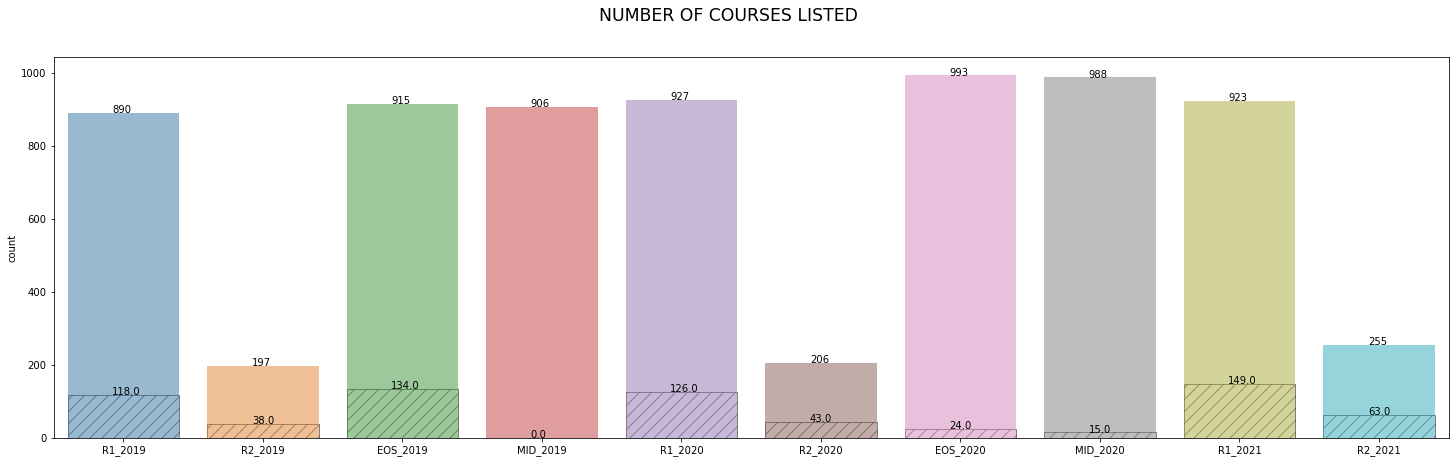

In [36]:
# Countplot (all listed courses).
fig, ax = plt.subplots(figsize = (25,7))
fig.suptitle ("NUMBER OF COURSES LISTED", size = "xx-large")
ax = sns.barplot(data = [[r1_2019_sy],[r2_2019_sy], [eos_2019_sy], 0, 
                   [r1_2020_sy],[r2_2020_sy], [eos_2020_sy], [mid_2020_sy],
                    [r1_2021_sy],[r2_2021_sy]],
                     fill = False, hatch="//", alpha = 0.5)
# Barplot (courses with symbols).
ax =  sns.countplot(data = df_numeric, alpha = 0.5)
    # Add values over the bars.
for p in ax.patches:
   ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()))
plt.show()

| |
| :-| 
| This plot shows the number of listed courses with points in Round 1 and Round 2, but also the EOS and MID, for each year. The hatched part of the bars show the number of courses in the total that had extra requirements other then just the points (e.g. Interview, Portfolio, All applicants accepted). | 

<br>
<br>

As stated before, certain courses have other conditions aside of points. Number of those for Round 1 and Round 2 are shown below.

#### Not all on this points score were offered places

In [37]:
# Function to filter out data with conditions.
def not_all(data, symbol):
    data = (data[(data.str.contains(symbol, na = False))])
    return data.count()

In [38]:
# Output
print ("ROUND 1:")
print ("There were", not_all(r1_2019, "\*" ), "courses that were not offered places in Round 1 2019.")
print ("There were", not_all(r1_2020, "\*" ), "courses that were not offered places in Round 1 2020.")
print ("There were", not_all(r1_2021, "\*" ), "courses that were not offered places in Round 1 2021.")
print ("ROUND 2:")
print ("There were", not_all(r2_2019, "\*" ), "courses that were not offered places in Round 2 2019.")
print ("There were", not_all(r2_2020, "\*" ), "courses that were not offered places in Round 2 2020.")
print ("There were", not_all(r2_2021, "\*" ), "courses that were not offered places in Round 2 2021.")

ROUND 1:
There were 34 courses that were not offered places in Round 1 2019.
There were 43 courses that were not offered places in Round 1 2020.
There were 75 courses that were not offered places in Round 1 2021.
ROUND 2:
There were 24 courses that were not offered places in Round 2 2019.
There were 29 courses that were not offered places in Round 2 2020.
There were 51 courses that were not offered places in Round 2 2021.


#### Test / Interview / Portfolio / Audition

In [39]:
# Output
print ("ROUND 1:")
print ("There were", not_all(r1_2019, "\#" ), "courses that had Test, Interview, Portfolio or Audition in Round 1 2019.")
print ("There were", not_all(r1_2020, "\#" ), "courses that had Test, Interview, Portfolio or Audition in Round 1 2020.")
print ("There were", not_all(r1_2021, "\#" ), "courses that had Test, Interview, Portfolio or Audition in Round 1 2021.")
print ("ROUND 2:")
print ("There were", not_all(r2_2019, "\#" ), "courses that had Test, Interview, Portfolio or Audition in Round 2 2019.")
print ("There were", not_all(r2_2020, "\#" ), "courses that had Test, Interview, Portfolio or Audition in Round 2 2020.")
print ("There were", not_all(r2_2021, "\#" ), "courses that had Test, Interview, Portfolio or Audition in Round 2 2021.")

ROUND 1:
There were 88 courses that had Test, Interview, Portfolio or Audition in Round 1 2019.
There were 87 courses that had Test, Interview, Portfolio or Audition in Round 1 2020.
There were 81 courses that had Test, Interview, Portfolio or Audition in Round 1 2021.
ROUND 2:
There were 15 courses that had Test, Interview, Portfolio or Audition in Round 2 2019.
There were 16 courses that had Test, Interview, Portfolio or Audition in Round 2 2020.
There were 17 courses that had Test, Interview, Portfolio or Audition in Round 2 2021.


#### All qualified applicants

In [40]:
# Output
print ("ROUND 1:")
print ("There were", not_all(r1_2019, "AQA" ), "courses that accepted all qualified applicants in Round 1 2019.")
print ("There were", not_all(r1_2020, "AQA" ), "courses that accepted all qualified applicants in Round 1 2020.")
print ("There were", not_all(r1_2021, "AQA" ), "courses that accepted all qualified applicants in Round 1 2021.")
print ("ROUND 2:")
print ("There were", not_all(r2_2019, "AQA" ), "courses that accepted all qualified applicants in Round 2 2019.")
print ("There were", not_all(r2_2020, "AQA" ), "courses that accepted all qualified applicants in Round 2 2020.")
print ("There were", not_all(r2_2021, "AQA" ), "courses that accepted all qualified applicants in Round 2 2021.")

ROUND 1:
There were 10 courses that accepted all qualified applicants in Round 1 2019.
There were 2 courses that accepted all qualified applicants in Round 1 2020.
There were 1 courses that accepted all qualified applicants in Round 1 2021.
ROUND 2:
There were 3 courses that accepted all qualified applicants in Round 2 2019.
There were 1 courses that accepted all qualified applicants in Round 2 2020.
There were 1 courses that accepted all qualified applicants in Round 2 2021.


#### New competition for available places

In [41]:
# Output
print ("ROUND 1:")
print ("There were", not_all(r1_2019, "v" ), "courses that had new competition for available places in Round 1 2019.")
print ("There were", not_all(r1_2020, "v" ), "courses that had new competition for available places in Round 1 2020.")
print ("There were", not_all(r1_2021, "v" ), "courses that had new competition for available places in Round 1 2021.")
print ("ROUND 2:")
print ("There were", not_all(r2_2019, "v" ), "courses that had new competition for available places in Round 2 2019.")
print ("There were", not_all(r2_2020, "v" ), "courses that had new competition for available places in Round 2 2020.")
print ("There were", not_all(r2_2021, "v" ), "courses that had new competition for available places in Round 2 2021.")

ROUND 1:
There were 0 courses that had new competition for available places in Round 1 2019.
There were 0 courses that had new competition for available places in Round 1 2020.
There were 0 courses that had new competition for available places in Round 1 2021.
ROUND 2:
There were 0 courses that had new competition for available places in Round 2 2019.
There were 3 courses that had new competition for available places in Round 2 2020.
There were 0 courses that had new competition for available places in Round 2 2021.


<br>
<br>

#### POINTS DISTRIBUTION

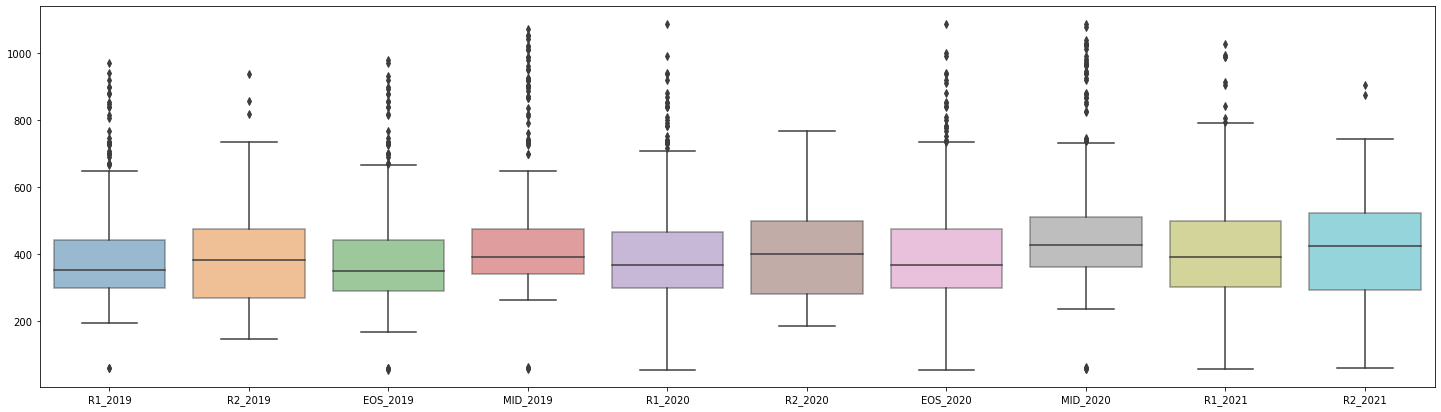

In [42]:
# Plotting.
fig, axs = plt.subplots(figsize = (25,7))
sns.boxplot(data = df_numeric, boxprops=dict(alpha=0.5))

plt.show()

| |
| :-| 
| Half of the courses have their points distributed mainly between 300 and 450. In general, the point distribution is in a range 100 to 800, with some outliners outside this range. Round 1 in 2020 has the most points on the lower side of the range, while Round 1 in 2021 has the most on the higher side of the range. | 

<br>
<br>

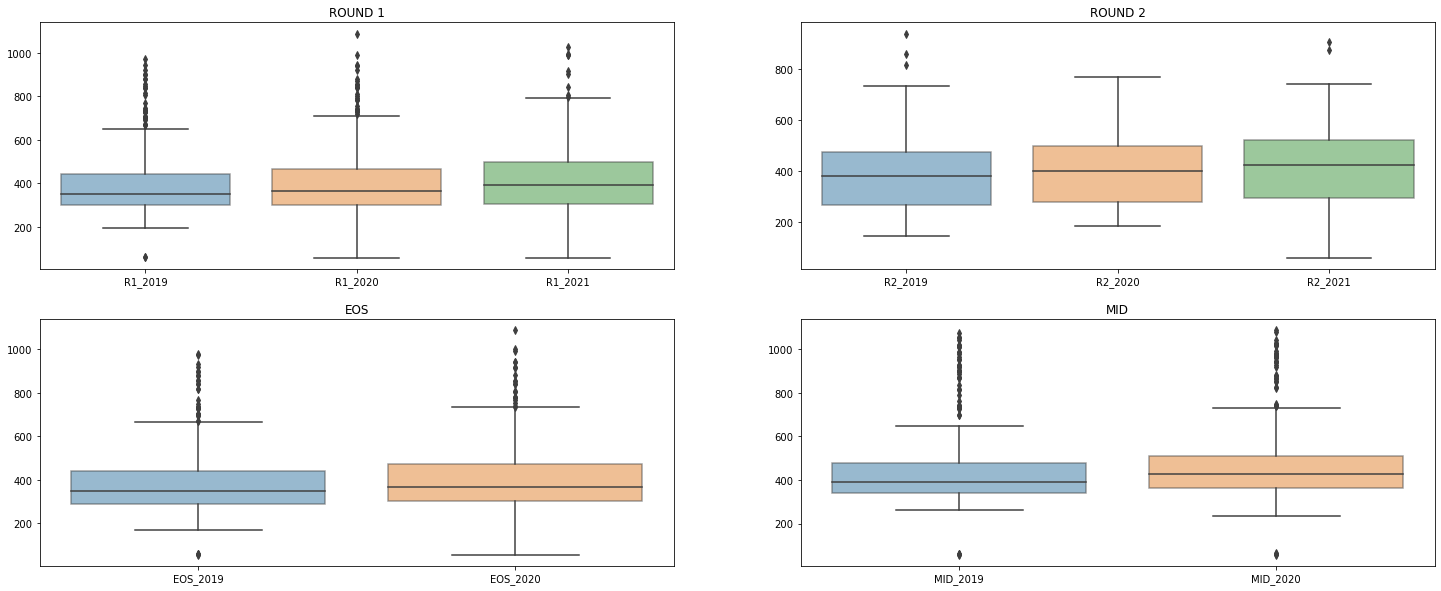

In [43]:
# Defining variables for plotting.
round1 = df_numeric [["R1_2019", "R1_2020", "R1_2021"]]
round2 = df_numeric [["R2_2019", "R2_2020", "R2_2021"]]
eos = df_numeric [["EOS_2019", "EOS_2020"]]
mid = df_numeric [["MID_2019", "MID_2020"]]

# Plotting.
fig, axs = plt.subplots(2, 2, figsize = (25,10))

sns.boxplot(data = round1, boxprops=dict(alpha=0.5), ax = axs[0,0])
axs[0,0].set( title = "ROUND 1")
sns.boxplot(data = round2, boxprops=dict(alpha=0.5), ax = axs[0,1])
axs[0,1].set( title = "ROUND 2")
sns.boxplot(data = eos, boxprops=dict(alpha=0.5), ax = axs[1,0])
axs[1,0].set( title = "EOS")
sns.boxplot(data = mid, boxprops=dict(alpha=0.5), ax = axs[1,1])
axs[1,1].set( title = "MID")

plt.show()

| | |
| :- | :-|
| Round 1 |  Half of the courses in 2019 have points between approx. 300 and 430. This spread increases with each year but remains around the similiar range. The total spread of the points also increases with each year. In 2019 there are not many courses with low points required. |
| Round 2 |  Similarly to Round 1, most of the points are spread around 400, with a small increase each year. Minimum points required were the lowest in 2021.|
| EOS | The spread in 2020 is bigger in 2020, compared to 2019. There are more courses with low and high values in 2020. |
| MID | Same as with EOS points, the spread is bigger in 2020. Most of the courses points are distributed in a slightly higher range. |

<br>
<br>

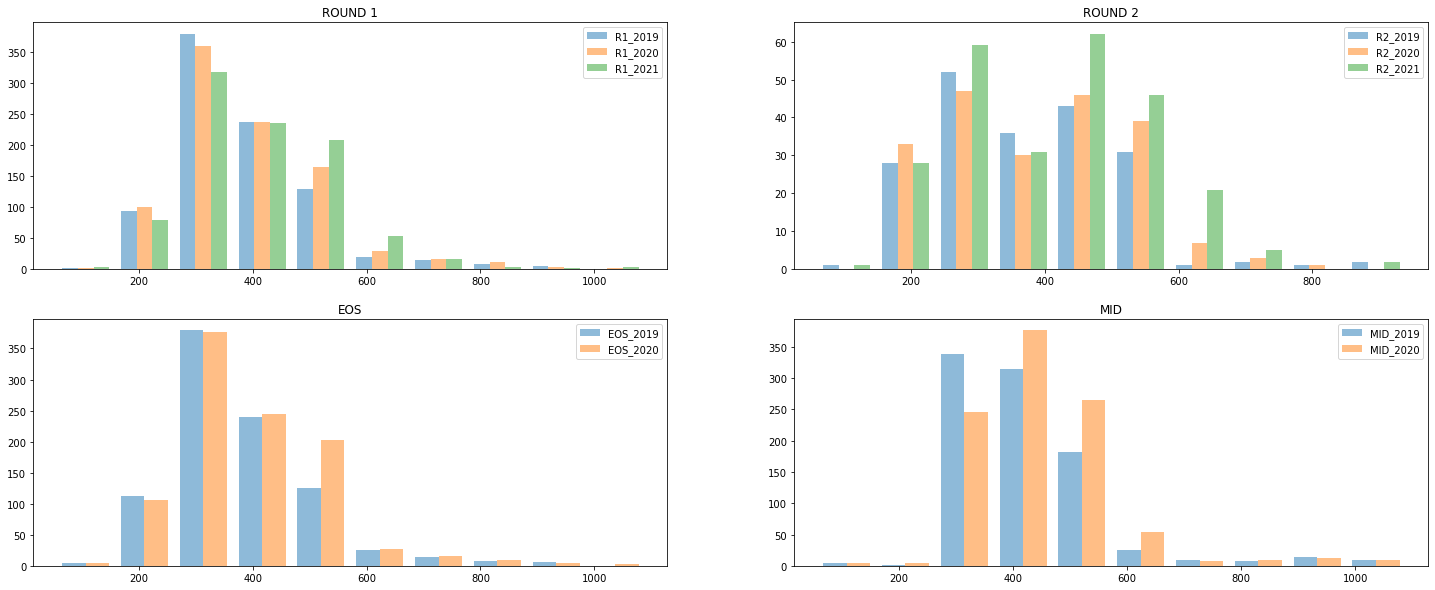

In [44]:
# Plotting.
fig, axs = plt.subplots(2, 2, figsize = (25,10))

axs[0,0].hist(round1, alpha = 0.5)
axs[0,0].set( title = "ROUND 1")
axs[0,0].legend(["R1_2019", "R1_2020", "R1_2021"])
axs[0,1].hist(round2, alpha = 0.5)
axs[0,1].set( title = "ROUND 2")
axs[0,1].legend(["R2_2019", "R2_2020", "R2_2021"])
axs[1,0].hist(eos, alpha = 0.5)
axs[1,0].set( title = "EOS")
axs[1,0].legend(["EOS_2019", "EOS_2020"])
axs[1,1].hist(mid, alpha = 0.5)
axs[1,1].set( title = "MID")
axs[1,1].legend(["MID_2019", "MID_2020"])
plt.show()

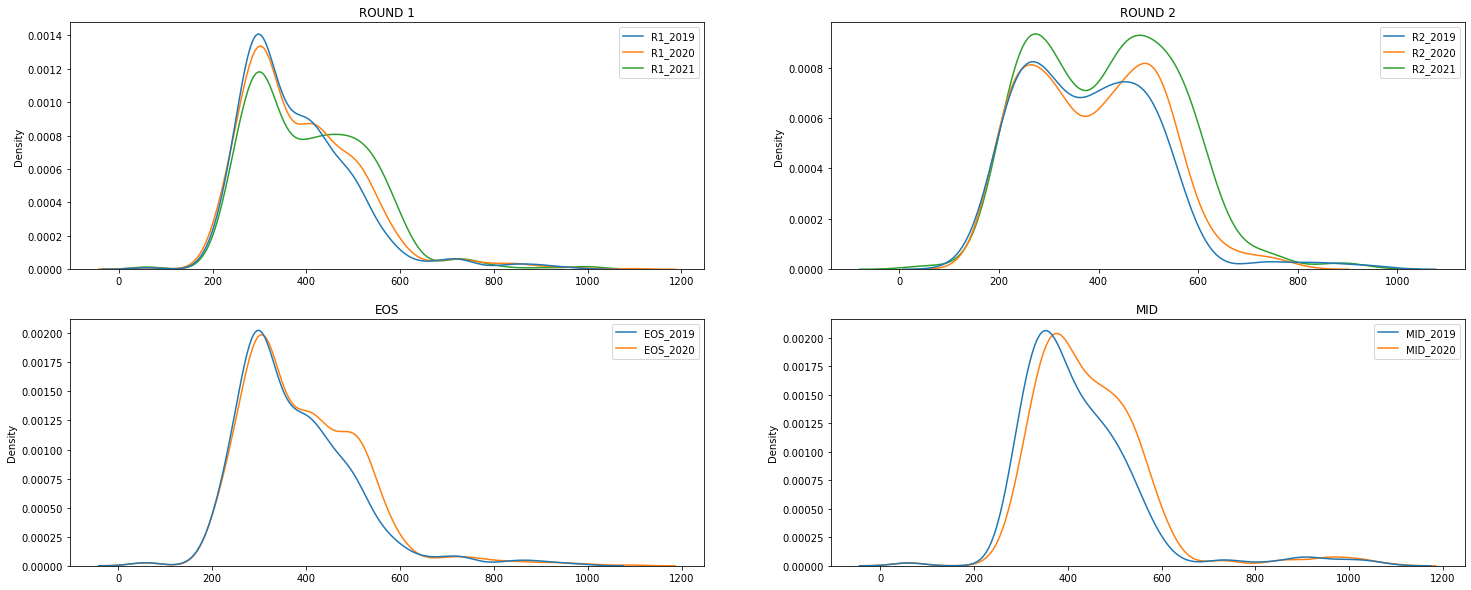

In [45]:
# Plotting.
fig, axs = plt.subplots(2, 2, figsize = (25,10))

sns.kdeplot(data = round1, ax = axs[0,0])
axs[0,0].set( title = "ROUND 1")
sns.kdeplot(data = round2, ax = axs[0,1])
axs[0,1].set( title = "ROUND 2")
sns.kdeplot(data = eos, ax = axs[1,0])
axs[1,0].set( title = "EOS")
sns.kdeplot(data = mid, ax = axs[1,1])
axs[1,1].set( title = "MID")

plt.show()

| | |
| :- | :-|
| Round 1 |  In all years, most of the courses fall into range from 200 to 600, with the highest number being arond 300. In 2021, there is more points closer to 600. |
| Round 2 |  In Round 2, the distribution is a bit different to Round 1. There are 2 high points, around 300 and 500. Most of the courses again fall into range from 200 to 600.|
| EOS and MID | EOS and MID points in both 2019 and 2020 are very similar to Round 1 points from the matching years. The high point is around 300 and most of the points are distributed in a range from 200 to 600. |

## REFERENCES
***

- [1] http://www2.cao.ie/handbook/handbook2022/hb.pdf
- [2] https://en.wikipedia.org/wiki/Central_Applications_Office7
- [3] https://www.independent.ie/life/family/learning/understanding-your-cao-course-guide-26505318.html
- [4] https://en.wikipedia.org/wiki/Regular_expression

#### CODE

- REQUESTS | https://docs.python-requests.org/en/latest/
- EXTRACT TABLES (CAMELOT) | https://www.thepythoncode.com/article/extract-pdf-tables-in-python-camelot
- MATCH LITTERAL SYMBOLS | https://stackoverflow.com/questions/9142736/python-regex-match-literal-asterisk
- CONCATENATE DATAFRAMES | https://stackoverflow.com/questions/52383287/concatenate-dataframes-in-a-for-loopENATE
- READ MULTIPLE CSV | https://stackoverflow.com/questions/55245721/read-in-multiple-csv-into-separate-dataframes-in-pandas/55245949
- HTLM.UNESCAPE | https://stackoverflow.com/questions/40399640/reading-csv-files-with-python-pandas-when-there-is-html-escaped-string-in-ther
- FILTER OUT NON-NUMBERS | https://stackoverflow.com/questions/44117326/how-can-i-remove-all-non-numeric-characters-from-all-the-values-in-a-particular
- CONVERT STRING TO FLOAT | https://datatofish.com/convert-string-to-float-dataframe/
- REPLACE VALUES IN DATAFRAME | https://datatofish.com/convert-string-to-float-dataframe/
- MATPLOTLIB PATTERN FILL | https://towardsdatascience.com/how-to-fill-plots-with-patterns-in-matplotlib-58ad41ea8cf8

#### CAMELOT

- CAMELOT INSTALLATION | https://camelot-py.readthedocs.io/en/master/user/install-deps.html#install-deps
- CAMELOT ISSUES FIX | https://github.com/atlanhq/camelot/issues/184
- CAMELOT ISSUES FIX | https://rnbeads.org/data/installing_rnbeads.html
- CAMELOT PAGE READ | https://stackoverflow.com/questions/56777241/camelot-is-reading-only-the-first-page-of-the-pdf

#### MARKDOWN

- CHECKBOX MARKDOWN | https://stackoverflow.com/questions/47344571/how-to-draw-checkbox-or-tick-mark-in-github-markdown-table/55523035
https://stackoverflow.com/questions/27975069/how-to-filter-rows-containing-a-string-pattern-from-a-pandas-dataframe

***
# THE END